# Example Burgers' equation with sequential training 

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
import numpy as np
import torch
from deepymod_torch.library_function import library_1D_in
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(40)
%load_ext autoreload
%autoreload 2

Next, we prepare the dataset.

In [2]:
data = np.load('../data/processed/burgers.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (256, 101)


Let's plot it to get an idea of the data:

In [3]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))

print(X.shape, y.shape)

(25856, 2) (25856, 1)


As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [4]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [5]:
number_of_samples = 1000

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [6]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

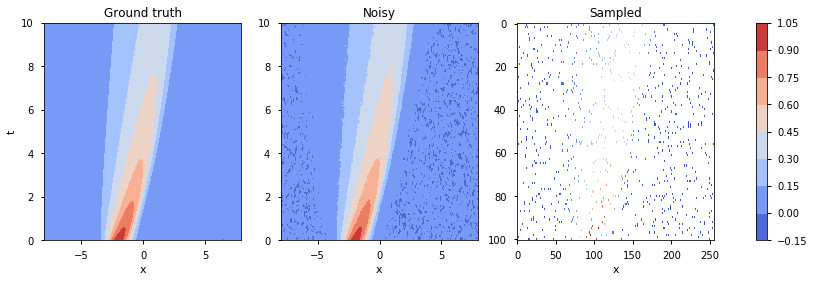

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configure the neural network

We now setup the options for DeepMoD. There's as few dictionaries to fill, starting with the 'optim config', which sets the maximal number of iterations and the amplitude of the $L_1$ penalty

In [8]:
optim_config = {'lambda': 10**-5, 'max_iterations': 5000, 'type': 'mse'}

Next we choose the size of the neural network 

In [9]:
network_config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for the burgers case accepts a maximum order for the polynomial and derivative terms.

In [10]:
library_config = {'type': library_1D_in, 'poly_order': 1, 'diff_order': 2}

## Run DeepMoD 

In [11]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

In [12]:
train(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE
0 8.1E-02 8.1E-02
500 2.0E-04 2.0E-04
1000 1.2E-04 1.2E-04
1500 2.4E-04 2.4E-04
2000 9.6E-05 9.6E-05
2500 9.2E-05 9.2E-05
3000 9.1E-05 9.1E-05
3500 8.9E-05 8.9E-05
4000 9.1E-05 9.1E-05
4500 8.6E-05 8.6E-05


In [13]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction = network(X_train)

In [14]:
time_deriv_list, theta = library_1D_in(X_train, prediction, library_config)

In [15]:
y_reg = time_deriv_list[0].detach().numpy()
x_reg = theta.detach().numpy()

In [27]:
vec =np.linalg.lstsq(x_reg,y_reg,rcond=None)[0]

In [28]:
coeff_vector_list

[tensor([[ 0.4960],
         [-0.5241],
         [ 1.1092],
         [ 0.1104],
         [-1.0365],
         [ 0.0700]], requires_grad=True)]

In [29]:
coeff_vector = [torch.tensor(vec, dtype=torch.float32, requires_grad=True)] 

In [30]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all)

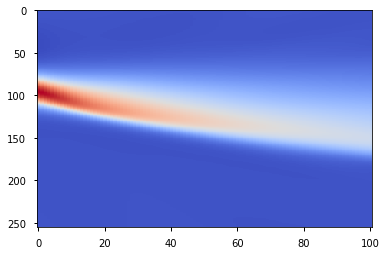

In [31]:
plt.imshow(prediction_full.detach().numpy().reshape(256, 101), aspect='auto', cmap='coolwarm')

In [32]:
optim_config = {'lambda': 10**-5, 'max_iterations': 5000, 'type': 'full'}

In [33]:
time_deriv_list, theta, coeff_vector_list = train(X_train, y_train, network, coeff_vector, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.6E-04 8.6E-05 5.9E-05 1.5E-05
tensor([[-0.0012],
        [-0.0501],
        [ 0.0905],
        [-0.0075],
        [-0.8547],
        [-0.0346]], requires_grad=True)
500 1.2E-04 8.9E-05 2.1E-05 1.4E-05
tensor([[ 6.9129e-04],
        [-4.6320e-02],
        [ 8.5887e-02],
        [-7.8437e-03],
        [-8.6706e-01],
        [-8.1126e-03]], requires_grad=True)
1000 1.1E-04 8.5E-05 1.5E-05 1.4E-05
tensor([[ 5.1399e-04],
        [-3.6325e-02],
        [ 8.9087e-02],
        [-5.7571e-03],
        [-8.9774e-01],
        [-5.3617e-03]], requires_grad=True)
1500 1.1E-04 8.3E-05 1.1E-05 1.4E-05
tensor([[ 3.4401e-04],
        [-2.9638e-02],
        [ 9.1461e-02],
        [-3.8415e-03],
        [-9.1906e-01],
        [-3.0842e-03]], requires_grad=True)
2000 1.1E-04 9.1E-05 8.3E-06 1.3E-05
tensor([[ 1.9258e-04],
        [-2.2033e-02],
        [ 9.2921e-02],
        [-1.5382e-03],
        [-9.4045e-01],
        [-8.0379e-04]], requires_grad=True)
2500 3.4E-04

In [34]:
print('Final result:')
print(sparse_coeff_vector, sparsity_mask)

Final result:
(tensor([[ 0.0994],
        [-1.0001]], requires_grad=True),) (tensor([2, 5]),)
